In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import pandas as pd

def read_labelimg_dataset(dataset_path):
    image_paths = []
    annotations = []

    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(dataset_path, filename)
            annotation_path = os.path.join(dataset_path, filename.replace('.jpg', '.txt'))

            if os.path.isfile(annotation_path):
                image_paths.append(image_path)
                with open(annotation_path, 'r') as f:
                    annotation_lines = f.readlines()

                annotation_data = []
                for line in annotation_lines:
                    parts = line.strip().split()
                    label = float(parts[0])
                    xmin = float(parts[1])
                    ymin = float(parts[2])
                    xmax = float(parts[3])
                    ymax = float(parts[4])

                    annotation_data.append({'label': label, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

                annotations.append(annotation_data)

    df = pd.DataFrame({'image_path': image_paths, 'annotations': annotations})
    return df

In [3]:
dataset_path = 'DATASET/'
df = read_labelimg_dataset(dataset_path)
df.head()

,image_path,annotations
0,DATASET/melon_1.jpg,"[{'label': 0.0, 'xmin': 0.826667, 'ymin': 0.59..."
1,DATASET/melon_10.jpg,"[{'label': 0.0, 'xmin': 0.46, 'ymin': 0.731667..."
2,DATASET/melon_100.jpg,"[{'label': 0.0, 'xmin': 0.432787, 'ymin': 0.59..."
3,DATASET/melon_101.jpg,"[{'label': 0.0, 'xmin': 0.131148, 'ymin': 0.13..."
4,DATASET/melon_102.jpg,"[{'label': 0.0, 'xmin': 0.367213, 'ymin': 0.18..."


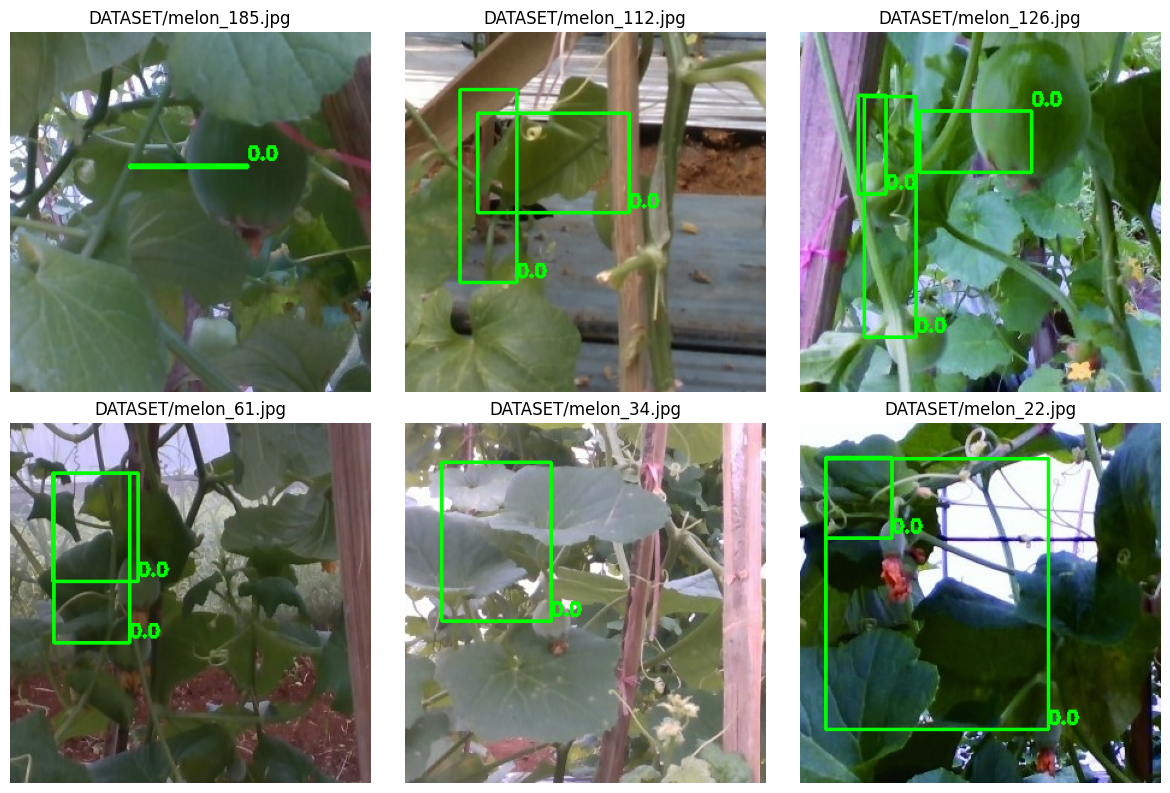

In [4]:
from pandas.core.dtypes.common import classes
# Ambil 6 gambar secara random
sample_df = df.sample(n=6, random_state=42)

def display_samples(sample_df):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, (_, row) in enumerate(sample_df.iterrows()):
        image_path = row['image_path']
        annotations = row['annotations']

        # Load the image using OpenCV
        image = cv2.imread(image_path)
        width, height, _ = image.shape

        for annotation in annotations:
            lable, x_min, y_min, x_max, y_max = annotation['label'], annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']

            x_min = int(float(x_min) * width)
            y_min = int(float(y_min) * height)
            x_max = int(float(x_max) * width)
            y_max = int(float(y_max) * height)

            # Draw a rectangle for the bounding box annotation
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Add label text to the bounding box
            image = cv2.putText(image, str(lable), (int(x_min), int(y_min) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Convert BGR to RGB for plotting with Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes and label names
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
        axes[i].set_title(image_path)

    plt.tight_layout()
    plt.show()

display_samples(sample_df)

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20)
train_df.head()

,image_path,annotations
152,DATASET/melon_56.jpg,"[{'label': 0.0, 'xmin': 0.751667, 'ymin': 0.42..."
67,DATASET/melon_16.jpg,"[{'label': 0.0, 'xmin': 0.575, 'ymin': 0.75333..."
133,DATASET/melon_39.jpg,"[{'label': 0.0, 'xmin': 0.371667, 'ymin': 0.51..."
59,DATASET/melon_152.jpg,"[{'label': 0.0, 'xmin': 0.52, 'ymin': 0.613333..."
63,DATASET/melon_156.jpg,"[{'label': 0.0, 'xmin': 0.3, 'ymin': 0.128333,..."


In [6]:
test_df.head()

,image_path,annotations
150,DATASET/melon_54.jpg,"[{'label': 0.0, 'xmin': 0.446667, 'ymin': 0.09..."
28,DATASET/melon_124.jpg,"[{'label': 0.0, 'xmin': 0.398333, 'ymin': 0.37..."
13,DATASET/melon_110.jpg,"[{'label': 0.0, 'xmin': 0.098361, 'ymin': 0.86..."
178,DATASET/melon_8.jpg,"[{'label': 0.0, 'xmin': 0.315, 'ymin': 0.43166..."
109,DATASET/melon_198.jpg,"[{'label': 0.0, 'xmin': 0.216667, 'ymin': 0.62..."


In [7]:
shape = (224, 224, 3)

# mobilenet
def mobilenet():
    inputs = keras.Input(shape)
    model = keras.applications.mobilenet.MobileNet(include_top=False, input_tensor=inputs, weights='imagenet')
    model.trainable = False

    x = model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(1)(x)

    return keras.Model(inputs, x)

# ssd
def ssd():
    inputs = keras.Input(shape)
    model = keras.applications.mobilenet.MobileNet(include_top=False, input_tensor=inputs, weights='imagenet')
    model.trainable = False

    x = model(inputs, training=False)
    x = keras.layers.Conv2D(4, kernel_size=3, padding='same')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(1)(x)

    return keras.Model(inputs, x)

# mixed from mobilenet and ssd
def mobilenetssd():
    inputs = keras.Input(shape)
    model = keras.applications.mobilenet.MobileNet(include_top=False, input_tensor=inputs, weights='imagenet')
    model.trainable = False

    x = model(inputs, training=False)
    x = keras.layers.Conv2D(4, kernel_size=3, padding='same')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(1)(x)

    return keras.Model(inputs, x)

# model
mobilenetssd_model = mobilenetssd()
mobilenetssd_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 4)           36868     
                                                                 
 global_average_pooling2d (  (None, 4)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5     